This notebook demonstrates how to pass a postprocessing pipeline while creating the Detector object
---

In [2]:
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    visualize_dataloader,
)
from tree_detection_framework.detection.detector import GeometricDetector
from tree_detection_framework.postprocessing.postprocessing import (
    merge_and_postprocess_detections,
    multi_region_hole_suppression,
    suppress_tile_boundary_with_NMS,
    single_region_hole_suppression,
    multi_region_NMS,
    single_region_NMS,
)


from tree_detection_framework.constants import DATA_FOLDER
from tree_detection_framework.detection.detector import (
    DeepForestDetector,
    Detectree2Detector,
)
from tree_detection_framework.detection.models import DeepForestModule, Detectree2Module


from pathlib import Path
import torch

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
# The path to a folder of raster images, e.g. orthomosaics stor
RASTER_FOLDER_PATH = Path(DATA_FOLDER, "emerald-point-ortho")
RASTER_FILE_PATH = Path(RASTER_FOLDER_PATH, "ortho.tif")
# Prediction file path
OUTPUT_PREDICTIONS_FILE_PATH = Path(
    DATA_FOLDER, "emerald-point-ortho-detectree2-predictions.gpkg"
)
# The size of the chips in pixels
CHIP_SIZE = 1024
# The stride between chips in pixels
CHIP_STRIDE = 768
# The spatial resolution that the data is sampled to in meters/pix
OUTPUT_RESOLUTION = 0.05
# The number of samples in a batch
BATCH_SIZE = 4
# Any detections below this threshold will be discarded
MIN_CONFIDENCE_THRESHOLD = 0.3
# Detections that overlap more than this threshold will be suppressed
IOU_NMS_THESHOLD = 0.3

# How many tiles to show
N_VIS_TILES = 3

# Choose the tree detction model you want to use from: "deepforest" and "detectree2"
TREE_DETECTOR = "detectree2"

# Setup the parameters dictionary use DeepForest
DEEPFOREST_MODEL_PARAMS = {
    "backbone": "retinanet",
    "num_classes": 1,
}
# Setup the parameters dictionary use Detectree2
DETECTREE2_MODEL_PARAMS = {
    "update_model": "/ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth"
}
# The device to use for inference, GPU or CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

1. GeometricDetector
----

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 400
Performing prediction on batches: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]
INFO:root:Bound have overlap, running across-region NMS


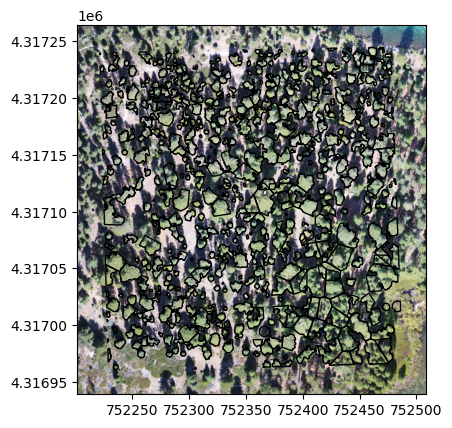

In [ ]:
dataloader = create_dataloader(
    raster_folder_path="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/chm.tif",
    chip_size=512,
    chip_stride=400,
    batch_size=3,
    output_resolution=0.2,
)

postprocessors = [
    (
        suppress_tile_boundary_with_NMS,
        {"iou_threshold": 0.5, "ios_threshold": 0.5, "min_confidence": 0.3},
    ),
    (
        single_region_NMS,
        {
            "confidence_column": "score",
            "threshold": 0.5,
            "min_confidence": 0.3,
        },
    ),
    (
        single_region_hole_suppression,
        {
            "min_area_threshold": 10,
        },
    ),
]

detector = GeometricDetector(
    a=0.0045,
    res=dataloader.sampler.res,
    confidence_factor="distance",
    filter_shape="square",
    postprocessors=postprocessors,
)

predictions = detector.predict(dataloader)

predictions.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

1. DeepForest
------

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 768


Reading config file: /ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Reading config file: /ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
Performing prediction on batches: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]
INFO:root:Bound have overlap, running across-region NMS


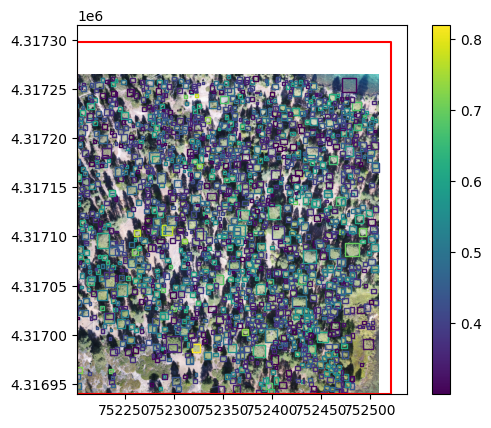

In [13]:
dataloader = create_dataloader(
    raster_folder_path=RASTER_FOLDER_PATH,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    output_resolution=OUTPUT_RESOLUTION,
    batch_size=BATCH_SIZE,
)

postprocessors = [
    (
        multi_region_NMS,
        {
            "confidence_column": "score",
            "threshold": 0.5,
            "min_confidence": 0.3,
        },
    ),
]

# This model uses pretrained weights from DeepForest
module = DeepForestModule(DEEPFOREST_MODEL_PARAMS).to(DEVICE)
detector = DeepForestDetector(module, postprocessors=postprocessors)

predictions = detector.predict(dataloader)

predictions.plot(
    visualization_column="score", bounds_color="r", raster_file=RASTER_FILE_PATH
)

3. Detectree2
----

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 768
INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...
Performing prediction on batches: 100%|██████████| 18/18 [01:41<00:00,  5.64s/it]
INFO:root:Bound have overlap, running across-region NMS


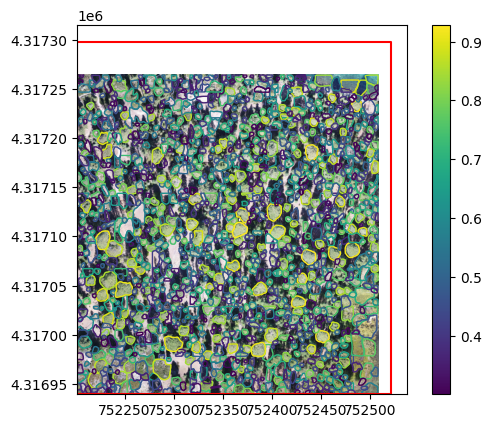

In [8]:
dataloader = create_dataloader(
    raster_folder_path=RASTER_FOLDER_PATH,
    chip_size=CHIP_SIZE,
    chip_stride=CHIP_STRIDE,
    output_resolution=OUTPUT_RESOLUTION,
    batch_size=BATCH_SIZE,
)

postprocessors = [
    (
        suppress_tile_boundary_with_NMS,
        {"iou_threshold": 0.5, "ios_threshold": 0.5, "min_confidence": 0.3},
    ),
    (
        single_region_NMS,
        {
            "confidence_column": "score",
            "threshold": 0.6,
            "min_confidence": 0.3,
        },
    ),
]

# This model uses pretrained weights from Detectree2
module = Detectree2Module(DETECTREE2_MODEL_PARAMS)
detector = Detectree2Detector(module, postprocessors=postprocessors)

predictions = detector.predict(dataloader)

predictions.plot(
    visualization_column="score", bounds_color="r", raster_file=RASTER_FILE_PATH
)